In [2]:
from dataclasses import dataclass
import os

import pandas as pd
import matplotlib.pyplot as plt

# Categorization

While the WDC benchmarks already offer categorization for the products, this is not the case for the Abt-Buy and Amazon-Google datasets. To create these categorizations, GPT-40 was used due to its high performance and relatively lower cost compared to GPT-4.

# Approach for Categorizing Products

We will employ a three-step approach to handle the datasets:

1. **Combining the Dataset Splits:** Start by merging the different splits of the dataset into a single unified set.
2. **Extracting Product IDs:** Next, extract every unique product ID from the combined dataset.
3. **Categorizing Products:** Lastly, categorize each product based on its title using a predefined classification scheme.

This structured approach will help ensure that all products are accurately categorized and easily accessible.


## WDC



In [3]:
def get_product_category(category_df: pd.DataFrame, cluser_id:int, product_key:str="predicted_CategoryLabel_majority_voted", cluster_key:str="cluster_id"):
    product = category_df[category_df[cluster_key] == cluser_id]

    if product.empty:
        return None
    else:
        return product[product_key].values[0]

## ABT-buy

In [4]:
abt_buy_product_categories = pd.read_csv("../data/abt-buy/categories/v2_complete.csv")
abt_buy_product_categories["category"] = abt_buy_product_categories["category"].apply(lambda x: x.replace("'", ""))

In [5]:
abt_buy_product_categories.head(2)

,Unnamed: 0,id,name,category
0,0,abt_730,lg 24 ' lds4821ww semi integrated built in whi...,Home_and_Garden
1,1,abt_670,speck seethru clear hard shell case for macboo...,Computers_and_Accessories


In [7]:
abt_buy_product_categories["category"].value_counts()

category
Other_Electronics              860
Camera_and_Photo               392
Home_and_Garden                287
Computers_and_Accessories      268
Automotive                     101
Office_Products                 50
Cell_Phones_and_Accessories     49
Video_Games                     41
Tools_and_Home_Improvement      41
Luggage_and_Travel_Gear         11
Musical_Instruments              3
CDs_and_Vinyl                    3
Jewelry                          2
Sports_and_Outdoors              1
Name: count, dtype: int64

In [6]:
# Load all dataset for the abt-buy benchmark 
abt_buy_train = pd.read_json("../data/abt-buy/abt-buy-train.json")
abt_buy_valid = pd.read_csv("../data/abt-buy/abt-buy-train-validation.csv")
abt_buy_test = pd.read_pickle("../data/abt-buy/abt-buy-sampled_gs.pkl")

In [7]:
abt_buy_train["product_category_left"] = abt_buy_train["id_left"].apply(lambda x: get_product_category(abt_buy_product_categories, x, "category", "id"))
abt_buy_train["product_category_right"] = abt_buy_train["id_right"].apply(lambda x: get_product_category(abt_buy_product_categories, x, "category", "id"))
abt_buy_valid["product_category_left"] = abt_buy_valid["id_left"].apply(lambda x: get_product_category(abt_buy_product_categories, x, "category", "id"))
abt_buy_valid["product_category_right"] = abt_buy_valid["id_right"].apply(lambda x: get_product_category(abt_buy_product_categories, x, "category", "id"))
abt_buy_test["product_category_left"] = abt_buy_test["id_left"].apply(lambda x: get_product_category(abt_buy_product_categories, x, "category", "id"))
abt_buy_test["product_category_right"] = abt_buy_test["id_right"].apply(lambda x: get_product_category(abt_buy_product_categories, x, "category", "id"))

In [8]:
abt_buy_test.head(2)

,id_left,title_left,description_left,price_left,cluster_id_left,id_right,title_right,description_right,price_right,cluster_id_right,label,pair_id,product_category_left,product_category_right
0,abt_942,sony bravia theater black micro system davis50b,sony bravia theater black micro system davis50...,,813,buy_949,sony bravia dav-is50 / b home theater system,"dvd player , 5.1 speakers 1 disc ( s ) progres...",,813,1,abt_942#buy_949,Other_Electronics,Other_Electronics
1,abt_599,belkin neoprene sleeve for macbook air f8n065blk,belkin neoprene sleeve for macbook air f8n065b...,,814,buy_545,belkin neoprene sleeve for macbook air neopren...,,,814,1,abt_599#buy_545,Computers_and_Accessories,Computers_and_Accessories


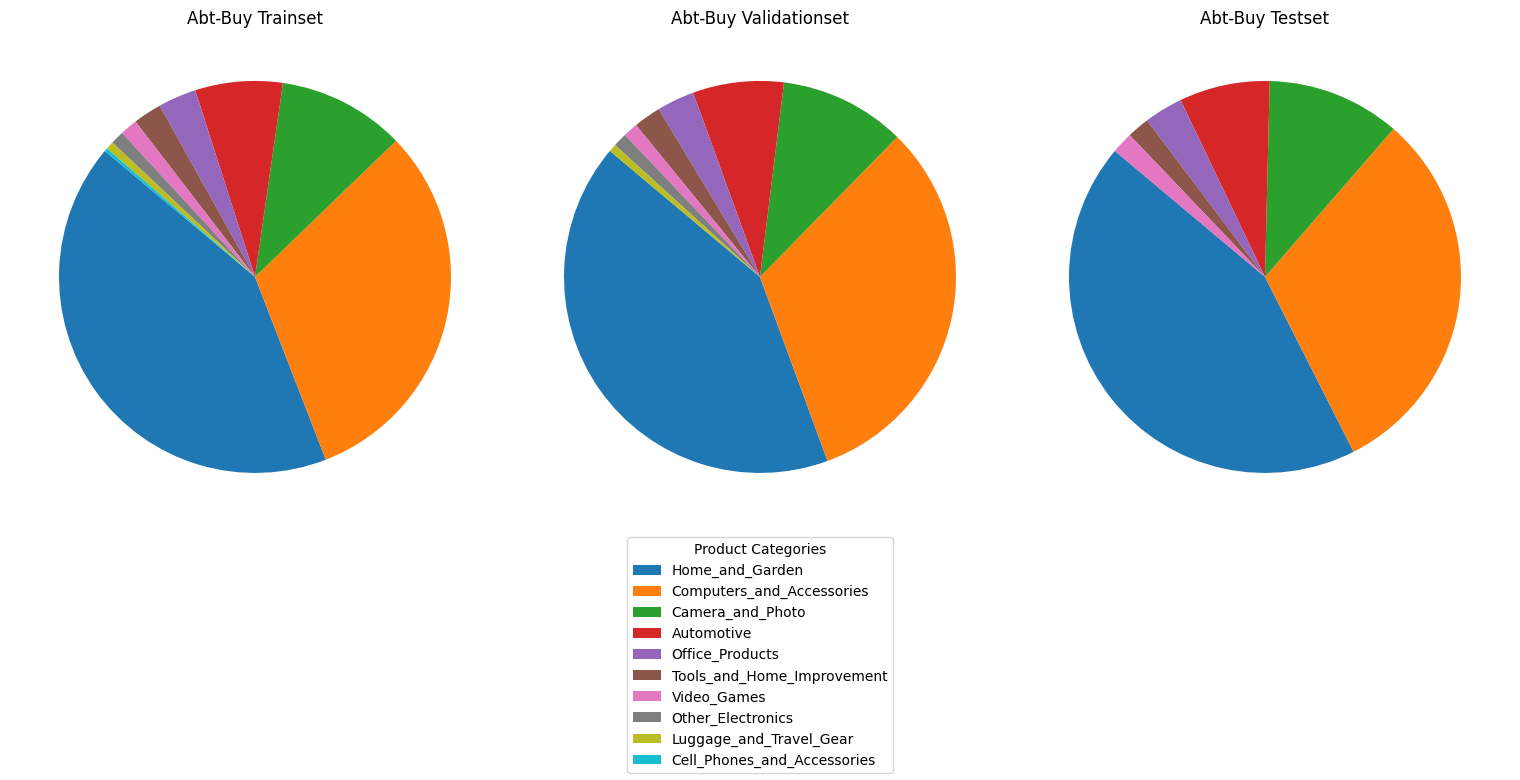

<Figure size 640x480 with 0 Axes>

In [9]:
# Updating the function to remove category names from the pies
def create_pie_chart(df, ax, title):
    category_counts = df['product_category_left'].value_counts()
    filtered_counts = category_counts[category_counts >= 10]
    wedges, texts = ax.pie(filtered_counts, autopct=None, startangle=140)
    ax.set_title(title)
    return wedges, filtered_counts.index

fig, axs = plt.subplots(1, 3, figsize=(18, 10))

# Create pie charts for each dataset
wedges1, labels1 = create_pie_chart(abt_buy_train, axs[0],'Abt-Buy Trainset')
wedges2, labels2 = create_pie_chart(abt_buy_valid, axs[1], 'Abt-Buy Validationset')
wedges3, labels3 = create_pie_chart(abt_buy_test, axs[2], 'Abt-Buy Testset')

# Combine labels for the legend, ensuring no duplicates
unique_labels = list(set(labels1).union(set(labels2)).union(set(labels3)))

# Adding a legend to the right
fig.legend(wedges1, unique_labels, loc='lower center', title='Product Categories')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Save the plot
plt.savefig("../plots/dataset/abt_categories.png")

10


/var/folders/0q/8f0zskws27x_14w3qmfndjfw0000gn/T/ipykernel_10345/2616225071.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ax.table(cellText=summary_df.applymap(lambda x: f"{x[0]} ({x[1]}%)").values, colLabels=summary_df.columns, rowLabels=summary_df.index, cellLoc='center', loc='center')


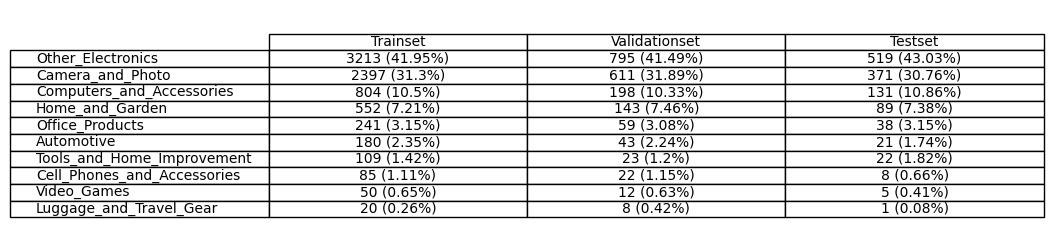

In [61]:
# Function to create a summary table of product categories
def create_summary_table(filter_df, *dfs, labels):
    summary = {}
    
    # Filtering the first dataframe
    category_counts = filter_df['product_category_left'].value_counts()
    filtered_categories = category_counts[category_counts >= 10].index
    print(len(filtered_categories))
    # Creating summary for the filtered categories in all dataframes
    for df, label in zip(dfs, labels):
        category_counts = df['product_category_left'].value_counts().reindex(filtered_categories, fill_value=0)
        percentage_counts = (category_counts / len(df) * 100).round(2)
        summary[label] = list(zip(category_counts.astype(int), percentage_counts))
        
    summary_df = pd.DataFrame(summary, index=filtered_categories)
    return summary_df

# Create the summary table
summary_df = create_summary_table(abt_buy_train, abt_buy_train, abt_buy_valid, abt_buy_test, labels=['Trainset', 'Validationset', 'Testset'])

# Sort summary table by the number of categories in the trainset
summary_df = summary_df.sort_values(by=("Trainset"), ascending=False)

# Converting to LaTeX (optional)
summary_df.to_latex("../plots/dataset/ag_categories_table.tex")

# Plot the table
fig, ax = plt.subplots(figsize=(10, 3))  # set size frame
ax.axis('tight')
ax.axis('off')
ax.table(cellText=summary_df.applymap(lambda x: f"{x[0]} ({x[1]}%)").values, colLabels=summary_df.columns, rowLabels=summary_df.index, cellLoc='center', loc='center')

plt.show()


In [ ]:
#cleanup the results
abt_buy_products["category"] = abt_buy_products["category"].apply(lambda x: x.replace("'", ""))
abt_buy_products["category"].value_counts()

## Amazon-Google

In [12]:
# Load all dataset for the abt-buy benchmark 
ag_train = pd.read_json("../data/amazon-google/amazon-google-train.json")
ag_valid = pd.read_csv("../data/amazon-google/amazon-google-train-validation.csv")
ag_test = pd.read_pickle("../data/amazon-google/amazon-google-sampled_gs.pkl")

In [13]:
ag_product_categories = pd.read_csv("../data/amazon-google/categories/complete.csv")
ag_product_categories["category"] = ag_product_categories["category"].apply(lambda x: x.replace("'", ""))

In [14]:
ag_train["product_category_left"] = ag_train["id_left"].apply(lambda x: get_product_category(ag_product_categories, x, "category", "id"))
ag_train["product_category_right"] = ag_train["id_right"].apply(lambda x: get_product_category(ag_product_categories, x, "category", "id"))
ag_valid["product_category_left"] = ag_valid["id_left"].apply(lambda x: get_product_category(ag_product_categories, x, "category", "id"))
ag_valid["product_category_right"] = ag_valid["id_right"].apply(lambda x: get_product_category(ag_product_categories, x, "category", "id"))
ag_test["product_category_left"] = ag_test["id_left"].apply(lambda x: get_product_category(ag_product_categories, x, "category", "id"))
ag_test["product_category_right"] = ag_test["id_right"].apply(lambda x: get_product_category(ag_product_categories, x, "category", "id"))

In [17]:
ag_train.head(2)

,id_left,title_left,manufacturer_left,price_left,cluster_id_left,id_right,title_right,manufacturer_right,price_right,cluster_id_right,label,pair_id,product_category_left,product_category_right
0,amazon_571,microsoft visio standard 2007 version upgrade,microsoft,129.95,8,google_946,adobe cs3 design standard upgrade,,413.99,766,0,amazon_571#google_946,Office_Products,Computers_and_Accessories
1,amazon_574,microsoft mappoint 2006 with gps,microsoft,349.0,297,google_2423,microsoft student with encarta premium 2008 co...,,43.60,198,0,amazon_574#google_2423,Computers_and_Accessories,Computers_and_Accessories


15


/var/folders/0q/8f0zskws27x_14w3qmfndjfw0000gn/T/ipykernel_10345/2555807215.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ax.table(cellText=summary_df.applymap(lambda x: f"{x[0]} ({x[1]}%)").values, colLabels=summary_df.columns, rowLabels=summary_df.index, cellLoc='center', loc='center')


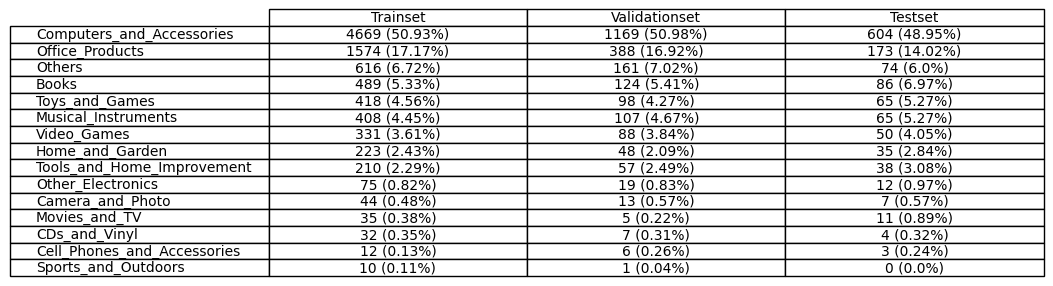

In [60]:
# Function to create a summary table of product categories
def create_summary_table(filter_df, *dfs, labels):
    summary = {}
    
    # Filtering the first dataframe
    category_counts = filter_df['product_category_left'].value_counts()
    filtered_categories = category_counts[category_counts >= 10].index
    print(len(filtered_categories))
    # Creating summary for the filtered categories in all dataframes
    for df, label in zip(dfs, labels):
        category_counts = df['product_category_left'].value_counts().reindex(filtered_categories, fill_value=0)
        percentage_counts = (category_counts / len(df) * 100).round(2)
        summary[label] = list(zip(category_counts.astype(int), percentage_counts))
        
    summary_df = pd.DataFrame(summary, index=filtered_categories)
    return summary_df

# Create the summary table
summary_df = create_summary_table(ag_train, ag_train, ag_valid, ag_test, labels=['Trainset', 'Validationset', 'Testset'])

# Sort summary table by the number of categories in the trainset
summary_df = summary_df.sort_values(by=("Trainset"), ascending=False)

# Converting to LaTeX (optional)
summary_df.to_latex("../plots/dataset/ag_categories_table.tex")

# Plot the table
fig, ax = plt.subplots(figsize=(10, 3))  # set size frame
ax.axis('tight')
ax.axis('off')
ax.table(cellText=summary_df.applymap(lambda x: f"{x[0]} ({x[1]}%)").values, colLabels=summary_df.columns, rowLabels=summary_df.index, cellLoc='center', loc='center')

plt.show()


# WDC

#

In [39]:
# Extract all categories from DWC
wdc_product_categories = pd.read_json("../data/wdc/categories/WDC_Corpus_LargeScaleExperiment_MajorityVoting.json.gz", lines=True, compression='gzip')

In [40]:
# Load all dataset for the abt-buy benchmark 
wdc_train = pd.read_pickle("../data/wdc/preprocessed_wdcproducts80cc20rnd000un_train_large.pkl")
wdc_valid = pd.read_pickle("../data/wdc/preprocessed_wdcproducts80cc20rnd000un_valid_large.pkl")
wdc_test = pd.read_csv("../data/wdc/preprocessed_wdcproducts80cc20rnd000unsampled250_2_gs_testset_ralph.csv")

In [41]:
# get all product ids
wdc_product_ids_left_train = wdc_train["cluster_id_left"].unique()
wdc_product_ids_right_train = wdc_train["cluster_id_right"].unique()
wdc_product_ids_left_valid = wdc_valid["cluster_id_left"].unique()
wdc_product_ids_right_valid = wdc_valid["cluster_id_right"].unique()
wdc_product_ids_left_test = wdc_test["cluster_id_left"].unique()
wdc_product_ids_right_test = wdc_test["cluster_id_right"].unique()


product_ids = set(wdc_product_ids_left_train).union(set(wdc_product_ids_right_train)).union(set(wdc_product_ids_left_valid)).union(set(wdc_product_ids_right_valid)).union(set(wdc_product_ids_left_test)).union(set(wdc_product_ids_right_test))

# filter wdc_categories for products in 13b
wdc_categories_testset = wdc_product_categories[wdc_product_categories["cluster_id"].isin(product_ids)]

In [48]:
wdc_train["product_category_left"] = wdc_train["cluster_id_left"].apply(lambda x: get_product_category(wdc_categories_testset, x, "predicted_CategoryLabel_majority_voted", "cluster_id"))
wdc_train["product_category_right"] = wdc_train["cluster_id_right"].apply(lambda x: get_product_category(wdc_categories_testset, x, "predicted_CategoryLabel_majority_voted", "cluster_id"))
wdc_valid["product_category_left"] = wdc_valid["cluster_id_left"].apply(lambda x: get_product_category(wdc_categories_testset, x, "predicted_CategoryLabel_majority_voted", "cluster_id"))
wdc_valid["product_category_right"] = wdc_valid["cluster_id_right"].apply(lambda x: get_product_category(wdc_categories_testset, x, "predicted_CategoryLabel_majority_voted", "cluster_id"))
wdc_test["product_category_left"] = wdc_test["cluster_id_left"].apply(lambda x: get_product_category(wdc_categories_testset, x, "predicted_CategoryLabel_majority_voted", "cluster_id"))
wdc_test["product_category_right"] = wdc_test["cluster_id_right"].apply(lambda x: get_product_category(wdc_categories_testset, x, "predicted_CategoryLabel_majority_voted", "cluster_id"))

In [49]:
wdc_test.head(2)

,id_left,brand_left,title_left,description_left,price_left,priceCurrency_left,specTableContent_left,cluster_id_left,id_right,brand_right,...,description_right,price_right,priceCurrency_right,specTableContent_right,cluster_id_right,pair_id,label,is_hard_negative,product_category_left,product_category_right
0,67017951,NaN,Ubiquiti UniFi Protect Video Security,Ubiquiti's UniFi Protect offers all the flexib...,NaN,NaN,NaN,1649038,5303451,NaN,...,The IR Range Extender is a 'Plug and Play' acc...,70.80,GBP,NaN,711907,67017951#5303451,0,True,Other_Electronics,Other_Electronics
1,41364196,NaN,Kšiltovka New Era Clean Trucker Chicago Bulls,NaN,658,CZK,NaN,46857262,29165749,NaN,...,NaN,810,CZK,NaN,76491423,41364196#29165749,0,True,Clothing,Clothing


18


/var/folders/0q/8f0zskws27x_14w3qmfndjfw0000gn/T/ipykernel_10345/513150664.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ax.table(cellText=summary_df.applymap(lambda x: f"{x[0]} ({x[1]}%)").values, colLabels=summary_df.columns, rowLabels=summary_df.index, cellLoc='center', loc='center')


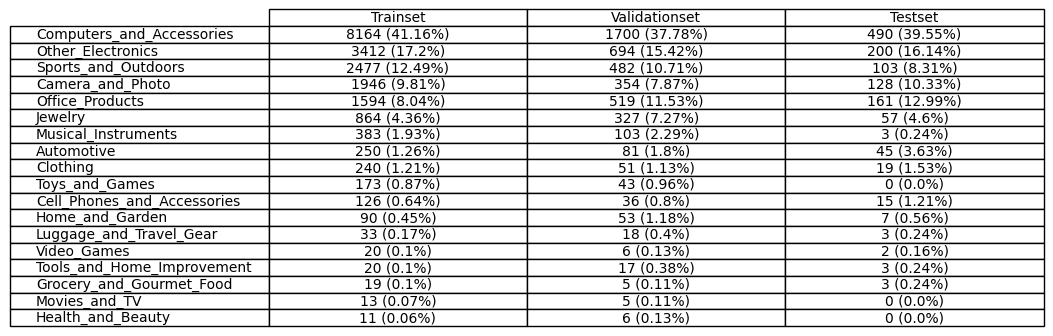

In [59]:
# Function to create a summary table of product categories
def create_summary_table(filter_df, *dfs, labels):
    summary = {}
    
    # Filtering the first dataframe
    category_counts = filter_df['product_category_left'].value_counts()
    filtered_categories = category_counts[category_counts >= 10].index
    print(len(filtered_categories))
    
    # Creating summary for the filtered categories in all dataframes
    for df, label in zip(dfs, labels):
        category_counts = df['product_category_left'].value_counts().reindex(filtered_categories, fill_value=0)
        percentage_counts = (category_counts / len(df) * 100).round(2)
        summary[label] = list(zip(category_counts.astype(int), percentage_counts))
        
    summary_df = pd.DataFrame(summary, index=filtered_categories)
    return summary_df

# Create the summary table
summary_df = create_summary_table(wdc_train, wdc_train, wdc_valid, wdc_test, labels=['Trainset', 'Validationset', 'Testset'])

# Sort summary table by the number of categories in the trainset
summary_df = summary_df.sort_values(by=("Trainset"), ascending=False)

# Converting to LaTeX (optional)
summary_df.to_latex("../plots/dataset/ag_categories_table.tex")

# Plot the table
fig, ax = plt.subplots(figsize=(10, 3))  # set size frame
ax.axis('tight')
ax.axis('off')
ax.table(cellText=summary_df.applymap(lambda x: f"{x[0]} ({x[1]}%)").values, colLabels=summary_df.columns, rowLabels=summary_df.index, cellLoc='center', loc='center')

plt.show()


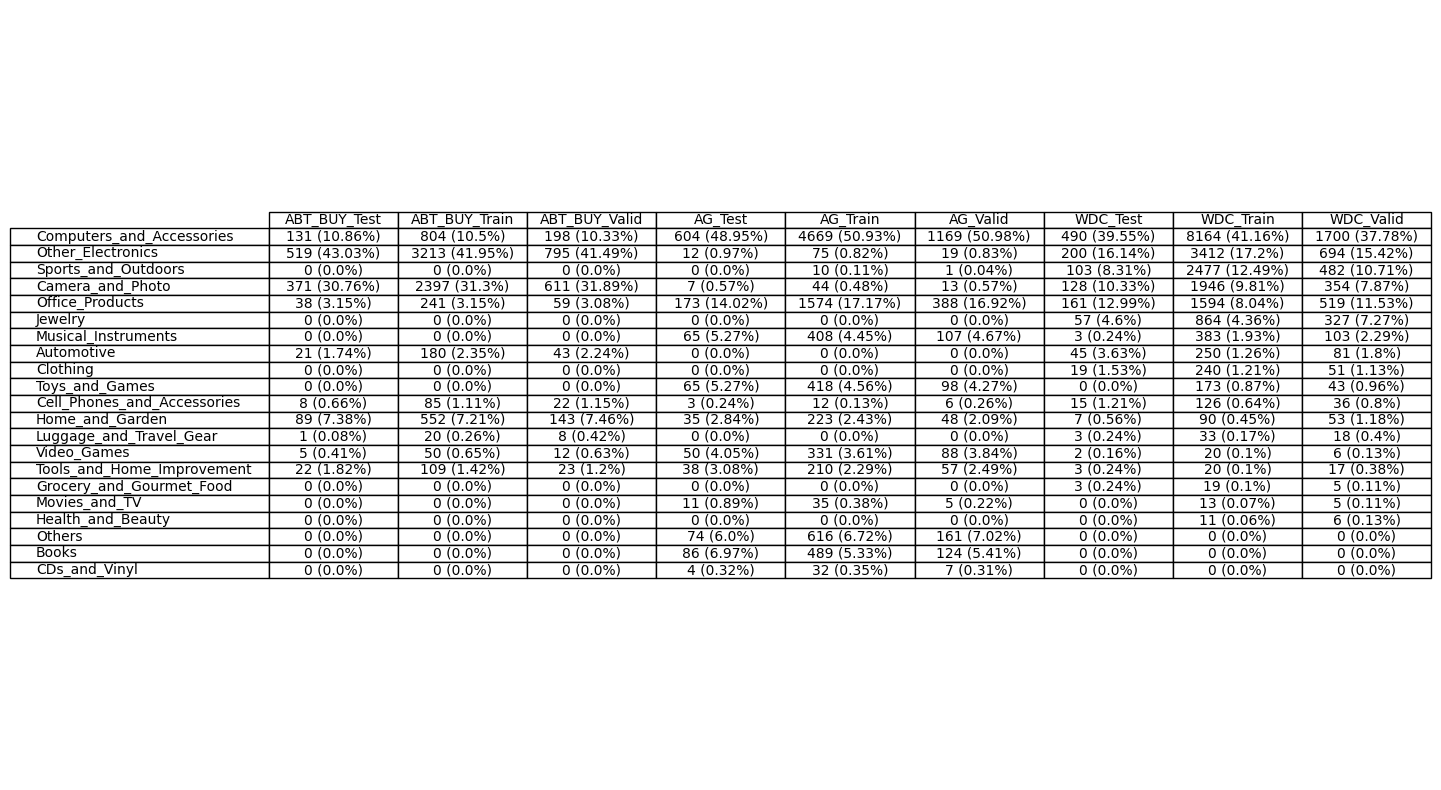

In [56]:
# Function to create a summary table of product categories for each dataset group
def create_summary_table(filter_df, *dfs, labels):
    summary = {}
    
    # Filtering the first dataframe
    category_counts = filter_df['product_category_left'].value_counts()
    filtered_categories = category_counts[category_counts >= 10].index
    
    # Creating summary for the filtered categories in all dataframes
    for df, label in zip(dfs, labels):
        category_counts = df['product_category_left'].value_counts().reindex(filtered_categories, fill_value=0)
        percentage_counts = (category_counts / len(df) * 100).round(2)
        summary[label] = pd.DataFrame({
            'Count': category_counts.astype(int),
            'Percentage': percentage_counts
        })
        
    summary_df = pd.concat(summary, axis=1).fillna(0)
    return summary_df

# Create summary tables for each dataset group
wdc_summary = create_summary_table(wdc_train, wdc_train, wdc_valid, wdc_test, labels=['WDC_Train', 'WDC_Valid', 'WDC_Test'])
ag_summary = create_summary_table(ag_train, ag_train, ag_valid, ag_test, labels=['AG_Train', 'AG_Valid', 'AG_Test'])
abt_buy_summary = create_summary_table(abt_buy_train, abt_buy_train, abt_buy_valid, abt_buy_test, labels=['ABT_BUY_Train', 'ABT_BUY_Valid', 'ABT_BUY_Test'])

# Combine the summary tables
combined_summary = pd.concat([wdc_summary, ag_summary, abt_buy_summary], axis=1).fillna(0)

# Sort the combined summary table by the number of categories in WDC_Train
combined_summary = combined_summary.sort_values(by=("WDC_Train", "Count"), ascending=False)

# Converting to LaTeX (optional)
combined_summary.to_latex("../plots/dataset/combined_categories_table.tex")

# Plot the table
fig, ax = plt.subplots(figsize=(15, 10))  # Adjusted size for more columns
ax.axis('tight')
ax.axis('off')

# Extract data and column labels for plotting
cell_text = []
for i in range(len(combined_summary)):
    row = []
    for col in combined_summary.columns.levels[0]:
        if col in combined_summary.columns.get_level_values(0):
            count, percentage = combined_summary[col].iloc[i]
            row.append(f"{int(count)} ({percentage}%)")
        else:
            row.append("0 (0.0%)")
    cell_text.append(row)

ax.table(cellText=cell_text, colLabels=combined_summary.columns.levels[0], rowLabels=combined_summary.index, cellLoc='center', loc='center')

plt.show()
